In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from os import listdir
from os.path import join
import os
import matplotlib.pyplot as plt
from dipy.core.sphere import disperse_charges, HemiSphere
import numpy as np
import pandas as pd
import cProfile
from tqdm import tqdm
from tqdm.contrib import itertools as tqdm_itertools
from scipy.ndimage import gaussian_filter

import sys
sys.path.insert(0,'../fibermetric/')
import sta_validate
import histology
import apsym_kmeans

## set parameters for 3D phantoms

In [3]:
shapes = [(72,72,72), (36,72,72), (24,72,72), (18,72,72), (14,72,72), (12,72,72), (10,72,72), (9,72,72)]
AI = [d[1]/d[0] for d in shapes]
periods = [7,10,13]
root = '../outputs/sta_validate_outputs/phantoms/phantoms-72/'
os.makedirs(root, exist_ok=True)

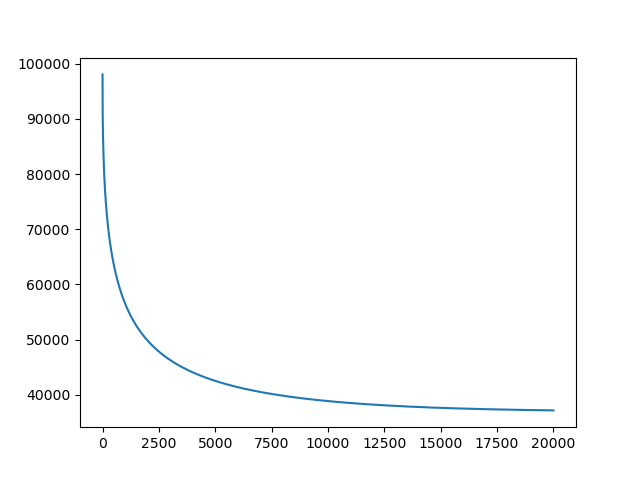

In [4]:
# get angles evenly distributed over a hemisphere

n_pts = 100
theta = np.pi - np.random.rand(n_pts)
phi = 2 * np.pi - np.random.rand(n_pts)
v_initial = HemiSphere(theta=theta, phi=phi)
v_updated, potential = disperse_charges(v_initial, 20000, const=0.1)
vertices = v_updated.vertices
plt.plot(potential)
plt.show()
angles = np.array([np.arccos(vertices[:,0]), np.arctan2(vertices[:,2],vertices[:,1])]).T


# thetas = np.linspace(0,np.pi/2,5)
# phis = np.linspace(0, np.pi/2, 5)
# angles = np.empty((5,5,2))
# for i in range(len(thetas)):
#     for j in range(len(phis)):
#         angles[i,j] = [thetas[i], phis[-(j+1)]]
# angles = angles.reshape(-1,2)[4:]
# print(angles)

In [ ]:
# this should give us close to 25 points per quadrant if it's distributed uniformly. 
octant0 = [a for a in angles if np.all(a <= np.pi/2) and np.all(a >= 0.0)]
print(len(octant0))
octant1 = [a for a in angles if a[0] <= np.pi/2 and a[1] >= np.pi/2]
print(len(octant1))
octant2 = [a for a in angles if a[0] >= np.pi/2 and a[1] <= np.pi/2]
print(len(octant2))
octant3 = [a for a in angles if a[0] >= np.pi/2 and a[1] >= np.pi/2]
print(len(octant3))
print(np.std(np.array([len(octant0),len(octant1),len(octant2),len(octant3)])))
print(len(angles))
print(potential[-1])
# np.save('../outputs/sta_validate_outputs/angles.npy', angles)

In [5]:
angles = np.load('../outputs/sta_validate_outputs/angles.npy')

In [6]:
for i in tqdm(range(len(shapes))):
    n = shapes[i]
    d = (n[1]/n[0], 1.0, 1.0)
    x = [np.arange(ni)*di for ni,di in zip(n,d)]

    for j,k in tqdm_itertools.product(range(len(periods)), range(len(angles))):
            p = periods[j]
            angle = angles[k]
            image = sta_validate.make_phantom(x,[angle], p)
            # save image
            name = f'phantom_AI-{d[0]:.2f}_period-{p:02d}_theta-{angle[0]:.2f}_phi-{angle[1]:.2f}'
            print(f'saving {root+name}')
            np.savez(join(root,name), image=image, AI=d[0], period=p, angle=angle)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-0.83_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-1.22_phi-1.26
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-2.43_phi-1.14
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-1.89_phi-0.33
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-1.54_phi-2.74
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-2.01_phi-2.53
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-1.97_phi-2.85
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-2.41_phi-2.88
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-07_theta-1.63_phi-3.03
saving ../outputs/sta_validate_outputs/phantom

 12%|█▎        | 1/8 [00:23<02:42, 23.20s/it]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-13_theta-0.88_phi-0.87
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-13_theta-1.93_phi-2.01
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-1.00_period-13_theta-1.29_phi-0.69


  0%|          | 0/300 [00:00<?, ?it/s]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-0.83_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-1.22_phi-1.26
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-2.43_phi-1.14
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-1.89_phi-0.33
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-1.54_phi-2.74
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-2.01_phi-2.53
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-1.97_phi-2.85
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-2.41_phi-2.88
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-07_theta-1.63_phi-3.03
saving ../outputs/sta_validate_outputs/phantom

 25%|██▌       | 2/8 [00:49<02:29, 24.88s/it]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-13_theta-0.88_phi-0.87
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-13_theta-1.93_phi-2.01
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-2.00_period-13_theta-1.29_phi-0.69


  0%|          | 0/300 [00:00<?, ?it/s]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-0.83_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-1.22_phi-1.26
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-2.43_phi-1.14
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-1.89_phi-0.33
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-1.54_phi-2.74
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-2.01_phi-2.53
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-1.97_phi-2.85
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-2.41_phi-2.88
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-07_theta-1.63_phi-3.03
saving ../outputs/sta_validate_outputs/phantom

 38%|███▊      | 3/8 [01:12<01:59, 23.92s/it]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-13_theta-0.88_phi-0.87
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-13_theta-1.93_phi-2.01
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-3.00_period-13_theta-1.29_phi-0.69


  0%|          | 0/300 [00:00<?, ?it/s]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-0.83_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-1.22_phi-1.26
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-2.43_phi-1.14
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-1.89_phi-0.33
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-1.54_phi-2.74
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-2.01_phi-2.53
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-1.97_phi-2.85
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-2.41_phi-2.88
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-07_theta-1.63_phi-3.03
saving ../outputs/sta_validate_outputs/phantom

 50%|█████     | 4/8 [01:32<01:30, 22.70s/it]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-13_theta-0.88_phi-0.87
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-13_theta-1.93_phi-2.01
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-4.00_period-13_theta-1.29_phi-0.69


  0%|          | 0/300 [00:00<?, ?it/s]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-0.83_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-1.22_phi-1.26
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-2.43_phi-1.14
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-1.89_phi-0.33
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-1.54_phi-2.74
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-2.01_phi-2.53
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-1.97_phi-2.85
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-2.41_phi-2.88
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-07_theta-1.63_phi-3.03
saving ../outputs/sta_validate_outputs/phantom

 62%|██████▎   | 5/8 [01:52<01:04, 21.60s/it]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-13_theta-0.88_phi-0.87
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-13_theta-1.93_phi-2.01
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-5.14_period-13_theta-1.29_phi-0.69


  0%|          | 0/300 [00:00<?, ?it/s]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-0.83_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-1.22_phi-1.26
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-2.43_phi-1.14
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-1.89_phi-0.33
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-1.54_phi-2.74
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-2.01_phi-2.53
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-1.97_phi-2.85
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-2.41_phi-2.88
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-07_theta-1.63_phi-3.03
saving ../outputs/sta_validate_outputs/phantom

 75%|███████▌  | 6/8 [02:11<00:41, 20.73s/it]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-13_theta-1.93_phi-2.01
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-6.00_period-13_theta-1.29_phi-0.69


  0%|          | 0/300 [00:00<?, ?it/s]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-0.83_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-1.22_phi-1.26
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-2.43_phi-1.14
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-1.89_phi-0.33
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-1.54_phi-2.74
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-2.01_phi-2.53
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-1.97_phi-2.85
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-2.41_phi-2.88
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-07_theta-1.63_phi-3.03
saving ../outputs/sta_validate_outputs/phantom

 88%|████████▊ | 7/8 [02:30<00:20, 20.05s/it]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-13_theta-1.93_phi-2.01
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-7.20_period-13_theta-1.29_phi-0.69


  0%|          | 0/300 [00:00<?, ?it/s]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-0.83_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-1.22_phi-1.26
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-2.43_phi-1.14
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-1.89_phi-0.33
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-1.54_phi-2.74
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-2.01_phi-2.53
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-1.97_phi-2.85
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-2.41_phi-2.88
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-07_theta-1.63_phi-3.03
saving ../outputs/sta_validate_outputs/phantom

100%|██████████| 8/8 [02:48<00:00, 21.07s/it]

saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-13_theta-1.84_phi-3.11
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-13_theta-0.88_phi-0.87
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-13_theta-1.93_phi-2.01
saving ../outputs/sta_validate_outputs/phantoms/phantoms-72/phantom_AI-8.00_period-13_theta-1.29_phi-0.69


## Add images for two angle phantoms

### first get all pair combinations. (n_angles choose 2 pairs) then choose a random subset of 100

In [ ]:
angle_pairs = [(a, b, a_idx, b_idx + a_idx + 1) for a_idx, a in enumerate(angles) for b_idx, b in enumerate(angles[a_idx+1:])]
angle_pair_ids = np.array([a[2:] for a in angle_pairs])
angle_pairs = np.array([a[:2] for a in angle_pairs])

ids = np.random.choice(len(angle_pairs), size=100, replace=False)

angle_pairs = angle_pairs[ids]
angle_pair_ids = angle_pair_ids[ids]
print(angle_pairs.shape)
print(angle_pair_ids.shape)

## how are delta angles distributed?

In [ ]:
direction_pairs = np.array([np.cos(angle_pairs[:,:,0]),
                            np.sin(angle_pairs[:,:,0])*np.cos(angle_pairs[:,:,1]),
                            np.sin(angle_pairs[:,:,0])*np.sin(angle_pairs[:,:,1])]).transpose(1,2,0)
print(direction_pairs.shape)

deltas = np.arccos(np.abs((direction_pairs[:,None,0] @ direction_pairs[:,1,...,None])[:,0,0]))

print(f'deltas min: {deltas.min()}, max: {deltas.max()}')
plt.hist(deltas)
plt.plot(np.ones(100)*np.mean(deltas), np.linspace(0,20,100), label='mean')
plt.plot(np.ones(100)*np.pi/4, np.linspace(0,20,100), label='center')
plt.legend()
plt.show()

In [ ]:
# np.save('../outputs/sta_validate_outputs/angle_pairs', angle_pairs)

## save two angle phantoms

In [6]:
angle_pairs = np.load('../outputs/sta_validate_outputs/angle_pairs.npy')

In [7]:
for i,d in enumerate(AI):
    n = shapes[i]
    dx = (n[1]/n[0], 1.0, 1.0)
    x = [np.arange(ni)*di for ni,di in zip(n,dx)]
    for p in periods:
        for a in angle_pairs:
            img = sta_validate.make_phantom(x, a, p)
            name = f'phantom_AI-{d:.2f}_period-{p:02d}_theta-{a[0,0]:.2f}-{a[1,0]:.2f}_phi-{a[0,1]:.2f}-{a[1,1]:.2f}'
            np.savez(join(root,name), image=img, AI=d, period=p, angle=a)

In [ ]:
for d in AI:
    for p in periods:
        for a in angle_pairs:
            files = listdir(root)
            I_file = [f for f in files if f.split('theta-')[1][:4]==f'{a[0,0]:.2f}' and f.split('phi-')[1][:4]==f'{a[0,1]:.2f}' and f.split('AI-')[1][:4]==f'{d:.2f}' and f.split('period-')[1][:2]==f'{p:02d}'][0]
            J_file = [f for f in files if f.split('theta-')[1][:4]==f'{a[1,0]:.2f}' and f.split('phi-')[1][:4]==f'{a[1,1]:.2f}' and f.split('AI-')[1][:4]==f'{d:.2f}' and f.split('period-')[1][:2]==f'{p:02d}'][0]
            I = np.load(join(root,I_file))['image']
            J = np.load(join(root,J_file))['image']
            new_phantom = I + J
            name = f'phantom_AI-{d:.2f}_period-{p:02d}_theta-{a[0,0]:.2f}-{a[1,0]:.2f}_phi-{a[0,1]:.2f}-{a[1,1]:.2f}'
            np.savez(join(root,name), image=new_phantom, AI=d, period=p, angle=a)

## Make phantoms with isotropic blur

In [8]:
# add isotropic blur to phantoms
out = '../outputs/sta_validate_outputs/phantoms/phantoms-72-iso-blur/'
files = listdir(root)
for f in tqdm(files):
    npz = np.load(join(root,f))
    image = npz['image']
    AI = npz['AI']
    period = npz['period']
    angle = npz['angle']
    dI = [float(AI), 1.0, 1.0]
    blur_factor = np.sqrt(dI[0]**2 - 1.0)
    new_image = gaussian_filter(image, sigma=[0.0, blur_factor, blur_factor])
    if angle.ndim == 1:
        name = f'phantom_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0]:.2f}_phi-{angle[1]:.2f}'
    else:
        name = f'phantom_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0,0]:.2f}-{angle[1,0]:.2f}_phi-{angle[0,1]:.2f}-{angle[1,1]:.2f}'
    np.savez(join(out,name), image=new_image, AI=AI, period=period, angle=angle)

100%|██████████| 4800/4800 [01:09<00:00, 69.16it/s]


# 2D Phantoms

## Set Parameters

In [9]:
shapes = [(96,96,96), (48,96,96), (32,96,96), (24,96,96), (19,96,96), (16,96,96), (14,96,96), (12,96,96)]
AI = [d[1]/d[0] for d in shapes]
periods = [7,10,13]
thetas = np.linspace(0,np.pi/2,100)

root = '../outputs/sta_validate_outputs/phantoms/phantoms_2d-96/'




In [ ]:
theta_pairs = [(a, b) for idx, a in enumerate(thetas) for b in thetas[idx+1:]]
ids = np.random.choice(len(theta_pairs), size=100, replace=False)
theta_pairs = np.array(theta_pairs)[ids]
# np.save('../outputs/sta_validate_outputs/theta_pairs', theta_pairs)

In [10]:
for i in tqdm(range(len(shapes))):
    n = shapes[i]
    d = (n[1]/n[0], 1.0)
    x = [np.arange(ni)*di for ni,di in zip(n,d)]

    for j,k in tqdm_itertools.product(range(len(periods)), range(len(thetas))):
            p = periods[j]
            angle = thetas[k]
            image = sta_validate.make_phantom(x,[angle], p)
            # save image
            name = f'phantom_AI-{d[0]:.2f}_period-{p:02d}_theta-{angle:.2f}'
            # print(f'saving {root+name}')
            np.savez(join(root,name), image=image, AI=d[0], period=p, angle=angle)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:01,  4.18it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.26it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.21it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.17it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.22it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.25it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  3.21it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:02<00:00,  3.27it/s]


In [11]:
theta_pairs = np.load('../outputs/sta_validate_outputs/theta_pairs.npy')
for i in tqdm(range(len(shapes))):
    n = shapes[i]
    d = (n[1]/n[0], 1.0)
    x = [np.arange(ni)*di for ni,di in zip(n,d)]

    for j,k in tqdm_itertools.product(range(len(periods)), range(len(theta_pairs))):
            p = periods[j]
            angle = theta_pairs[k]
            image = sta_validate.make_phantom(x,angle, p)
            # save image
            name = f'phantom_AI-{d[0]:.2f}_period-{p:02d}_theta-{angle[0]:.2f}-{angle[1]:.2f}'
            # print(f'saving {root+name}')
            np.savez(join(root,name), image=image, AI=d[0], period=p, angle=angle)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:02,  3.13it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:02,  2.79it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.74it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.75it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.85it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.89it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.98it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


In [12]:
len(files)

4800

In [13]:
# add isotropic blur to phantoms
out = '../outputs/sta_validate_outputs/phantoms/phantoms_2d-96-iso-blur/'
files = listdir(root)
for f in tqdm(files):
    npz = np.load(join(root,f))
    image = npz['image']
    AI = npz['AI']
    period = npz['period']
    angle = npz['angle']
    blur_factor = np.sqrt(float(AI)**2 - 1.0)
    new_image = gaussian_filter(image, sigma=[0., blur_factor])
    if angle.ndim == 0:
        name = f'phantom_AI-{AI:.2f}_period-{period:02d}_theta-{angle:.2f}'
    else:
        name = f'phantom_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0]:.2f}-{angle[1]:.2f}'
    np.savez(join(out,name), image=new_image, AI=AI, period=period, angle=angle)

100%|██████████| 4800/4800 [00:05<00:00, 826.35it/s]


# Structure Tensor Analysis on premade phantoms

In [ ]:
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=10.0, num=10)
print(derivative_sigmas)
print(tensor_sigmas)
print(thetas)

In [ ]:
# name = root+'phantom_AI-1.00_period-8_theta-0.00-0.39_phi-0.00.npy'
name = root+'phantom_AI-1.00_period-12_theta-0.00-1.57_phi-0.00.npy'
phantom = np.load(name)
d = 2
t = 1
with cProfile.Profile() as pr:
    error = sta_validate.sta_test(phantom, derivative_sigmas[d], tensor_sigmas[t], true_thetas=[(0.0,0.0), (thetas[4],0.0)])
    print(error)/home/brysongray
    pr.print_stats(sort='tottime')

In [ ]:
fig,ax = plt.subplots(3)
ax[0].imshow(phantom[36,:,:])
ax[1].imshow(phantom[:,36,:])
ax[2].imshow(phantom[:,:,36])

In [ ]:
phi1_phantoms = [f for f in listdir(root) if f.split('phi-')[1][:4]=='0.39']
print(len(phi1_phantoms))

In [ ]:
# run structure tensor analysis for every phantom
# I need to get the actual parameter values given the rounded values in the file name
error_df = pd.DataFrame({'derivative_sigma':[], 'tensor_sigma':[], 'AI':[], 'period':[],
                         'width':[], 'angles':[], 'error':[]})
d = np.array([n[1]/n[0] for n in shapes])
for f in listdir(root):
    AI_ = float(f.split('AI-')[1][:4])
    AI = d[np.argmin(np.abs(d - AI_))]
    period = int(f.split('period-')[1][:2])
    phi_ = float(f.split('phi-')[1][:4])
    phi = phis[np.argmin(np.abs(phis - phi_))]
    theta_ = f.split('theta-')[1][:9].split('-')
    if len(theta_[1]) == 0:
        theta = thetas[np.argmin(np.abs(thetas - float(theta_[0][:4])))]
        angles = [(theta, phi)]
    else:
        theta = [thetas[np.argmin(np.abs(thetas - float(theta_[0][:4])))],
                  thetas[np.argmin(np.abs(thetas - float(theta_[1][:4])))]]
        angles = [(theta[0], phi), (theta[1], phi)]
    
    # phantom = np.load(root+f)
    for sigma0 in derivative_sigmas:
        for sigma1 in tensor_sigmas:
            # error = sta_validate.sta_test(phantom, sigma0, sigma1, true_thetas=angles)
            new_row = {'derivative_sigma': sigma0, 'tensor_sigma': sigma1, 'AI': AI, 'period': period, 'width': 1, 'angles': [angles], 'error': 0}
            error_df = pd.concat([error_df, pd.DataFrame(new_row)], ignore_index=True)

    


In [ ]:
# 2d
root = '../outputs/sta_validate_outputs/phantoms/phantoms_2d-96/'
files = os.listdir(root)
# one angle
# file = files[0]
# two angles
file = files[2]

# # 3d
# root = '../outputs/sta_validate_outputs/phantoms/phantoms-72_v2/'
# files = os.listdir(root)
# # one angle
# file = files[3]
# # two angles
# # file = files[0]

# print(file)
# # npz = np.load(join(root, files[3]))
# npz = np.load(join(root, file))
# phantom = npz['image']
# AI = npz['AI']
# period = npz['period']
# angle = npz['angle']
# # angle = np.array([angle])
# print(angle)
# error_df = pd.DataFrame({'derivative_sigma':[], 'tensor_sigma':[], 'AI':[], 'period':[],
#                         'width':[], 'angles':[], 'error':[]})
# sigma0 = 1.0
# sigma1 = 1.0
# error = sta_validate.sta_test(phantom, derivative_sigma=sigma0, tensor_sigma=sigma1, true_thetas=angle, crop=12)

# new_row = {'derivative_sigma': sigma0, 'tensor_sigma': sigma1,
#                         'AI': AI, 'period': period, 'width': 1,
#                         'angles': [angle], 'error': error}
# error_df = pd.concat((error_df, pd.DataFrame(new_row)), ignore_index=True)

# # save dataframe using pickle
# if phantom.ndim == 2:
#     if angle.ndim == 0:
#         name = f'error_AI-{AI:.2f}_period-{period:02d}_theta-{angle:.2f}.p'
#     else:
#         name = f'error_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0]:.2f}-{angle[1]:.2f}.p'

# if phantom.ndim == 3:
#     if angle.ndim == 1:
#             name = f'error_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0]:.2f}_phi-{angle[1]:.2f}.p'
#     else:
#         name = f'error_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0,0]:.2f}-{angle[1,0]:.2f}_phi-{angle[0,1]:.2f}-{angle[1,1]:.2f}.p'

# print(f'saving {name}')


In [ ]:
plt.close('all')

In [ ]:
n = (72, 72, 72)
d = (1.0, 1.0, 1.0)
x = [np.arange(ni)*di for ni, di in zip(n, d)]
thetas = np.array([np.pi/3, 0.0])
img = sta_validate.make_phantom(x, [thetas], period=7)

plt.figure()
plt.imshow(img[...,36])

In [ ]:
sigma0 = 1.0
sigma1 = 5.0
S = histology.structure_tensor(img, derivative_sigma=sigma0, tensor_sigma=sigma1, dI=d, masked=False)
angles = histology.angles(S, cartesian=True)
fig, ax = plt.subplots(1,3)
ax[0].imshow(angles[...,36,0], cmap='hsv')
ax[1].imshow(angles[...,36,1], cmap='hsv')
ax[2].imshow(angles[...,36,2], cmap='hsv')

In [ ]:
# convert true_thetas to cartesian coordinates for easier error calculation
true_thetas = np.array(thetas)
if true_thetas.ndim == 1:
    true_thetas = np.array([np.sin(true_thetas[0])*np.sin(true_thetas[1]),
                                    np.sin(true_thetas[0])*np.cos(true_thetas[1]),
                                    np.cos(true_thetas[0])
                                    ])
    skm = apsym_kmeans.APSymKMeans(n_clusters=1)
elif true_thetas.ndim == 2:
    true_thetas = np.array([np.sin(true_thetas[:,0])*np.sin(true_thetas[:,1]),
                                    np.sin(true_thetas[:,0])*np.cos(true_thetas[:,1]),
                                    np.cos(true_thetas[:,0])
                                    ]).T
    skm = apsym_kmeans.APSymKMeans(n_clusters=2)

angles_ = angles.reshape(-1,3)
skm.fit(angles_)
mu_ = skm.cluster_centers_

In [ ]:
print(mu_)
diff = np.arccos(np.abs(mu_.dot(true_thetas))) * 180/np.pi 
print(diff)

In [ ]:
error = sta_validate.sta_test(img, sigma0, sigma1, true_thetas=thetas, crop=12)

In [ ]:
error